## Setup the default forcing

In [ ]:
from matplotlib import rc
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
os.chdir("/home/149/ab8992/topographic-NIWs")
basepath = Path.cwd().absolute()

import autolib as al
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42171,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:34703,Total threads: 4
Dashboard: /proxy/35979/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:38027,


In [ ]:
import autolib as al


### COMMON ACROSS ALL EXPERIMENTS. 
##########################################################
nlayers = 20             # number of layers
Lx = 4000                # domain zonal extent [km]
Ly = 4000                # domain meridional extent [km]
H  = 4000                # total fluid's depth in [m]
gridspacing = 2          # in [km]
flat = False
reverse = True
x = np.arange(-Lx/2, Lx/2, gridspacing)
y = np.arange(-Ly/2, Ly/2, gridspacing)
ninterf = nlayers + 1    # number of interfaces
interfaces = np.arange(0,  ninterf)
nx = int(round(Lx/gridspacing))
ny = int(round(Ly/gridspacing))
overrides = ["ADIABATIC = True",
             "RHO_0 = 1025.0",
             f"NJGLOBAL={ny}",
             f"NIGLOBAL={nx}",
             f"LENLON = {Lx}.0",
             f"WESTLON = -{Lx//2}.0",
             f"LENLAT = {Ly}.0",
             f"WESTLAT = -{Ly//2}.0",
             f"NK = {nlayers}"]
default_dir = "default_rundir"


## Default values when unperturbed
default_height = 500 # m
default_forcing_latwidth = 300 # km
default_duration = 5 # hours
default_layerdensities = np.linspace(1025 - 21,1025 + 21,nlayers) ## This is the default stratification
default_strength = 1
default_ridge_width = 12.5 # km


## Value s from first pass! 
## Perterbation values
## strat variables 
strats = [0.25,0.2,0.5,0.75,1,1.25,1.5,2,3,4,0.001,0.01,6]

## Height
heights = [10,20,50,80,120,150,225,275,350,450,600,750,1000,1250,1500,2000] + [500,650,700]

## Duration
durations = [0.5,1,2,3,4,5,6,8.7,10] + [7,8,12,14,15,16,20] ## Note! Will need to modify the amount of time that model runs for with forcing in this case

## Strength
strengths = [0.1,0.2,0.5,0.75,1,1.25,1.5,2,3,4,10] + [5,6,7,8,9]

## Topog Width
widths = [4,8,12.5,16,25,35,50,100,200] + [75,125,150,300,400,500,600,700,800,1000]

## Forcing Width
forcing_widths = [25,50,75,100,150,175,200,300,500,800,1000] + [250,400]



## Check default model run outputs

In [5]:
zonal

<xarray.Dataset> Size: 3GB
Dimensions:  (xh: 2000, yh: 10, zi: 21, time: 330, xq: 2001, zl: 20, yq: 11)
Coordinates:
  * xh       (xh) float64 16kB -1.999e+03 -1.997e+03 ... 1.997e+03 1.999e+03
  * yh       (yh) float64 80B -9.0 -7.0 -5.0 -3.0 -1.0 1.0 3.0 5.0 7.0 9.0
  * zi       (zi) float64 168B 1.004e+03 1.006e+03 ... 1.044e+03 1.046e+03
  * time     (time) float64 3kB 1.2e+03 2.4e+03 3.6e+03 ... 3.948e+05 3.96e+05
  * xq       (xq) float64 16kB -2e+03 -1.998e+03 -1.996e+03 ... 1.998e+03 2e+03
  * zl       (zl) float64 160B 1.005e+03 1.007e+03 ... 1.043e+03 1.045e+03
  * yq       (yq) float64 88B -10.0 -8.0 -6.0 -4.0 -2.0 0.0 2.0 4.0 6.0 8.0 10.0
Data variables:
    e        (time, zi, yh, xh) float64 1GB dask.array<chunksize=(15, 11, 5, 1000), meta=np.ndarray>
    taux     (time, yh, xq) float32 26MB dask.array<chunksize=(30, 10, 2001), meta=np.ndarray>
    u        (time, zl, yh, xq) float64 1GB dask.array<chunksize=(15, 10, 5, 1001), meta=np.ndarray>
    v        (time, zl, yq, xh) float64 1GB dask.array<chunksize=(15, 10, 6, 1000), meta=np.ndarray>

In [ ]:
merid = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/outputdir/height_500/merid/*.nc",decode_times = False,decode_cf = False).isel(xq = 0,xh = 0).load()
zonal = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/outputdir/height_500/zonal/*.nc",decode_times = False,decode_cf = False)
zonal_anom = zonal.u.sel(yh = 0,method = "nearest") - merid.u.sel(yh = 0,method = "nearest").load()



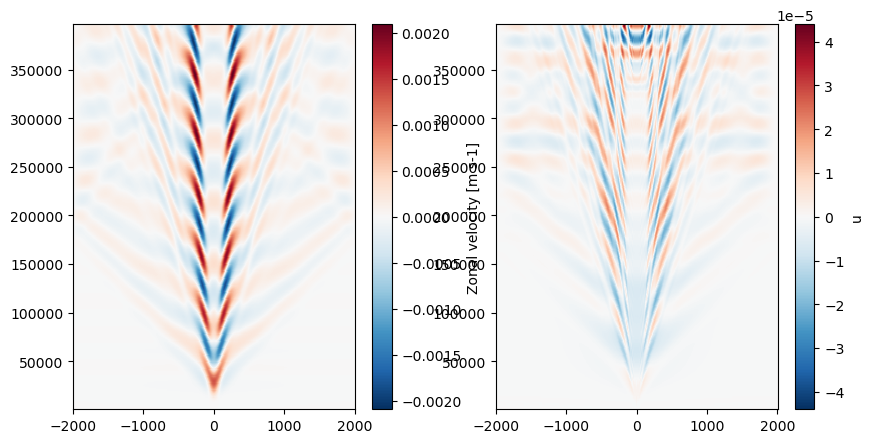

In [ ]:

import matplotlib.pyplot as plt

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (10,5))

zonal_anom = zonal.u.sel(yh = 0,method = "nearest") - merid.u.sel(yh = 0,method = "nearest")

merid.u.isel(zl = 5).plot(ax=ax1)
zonal_anom.isel(zl = 5).plot(ax=ax2)

# Remove titles and axis labels
ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_title('')
ax2.set_xlabel('')
ax2.set_ylabel('')

# Display the plots
plt.show()

In [ ]:
def groupspeed(n,N,L):
    f = 1e-4
    N = N * f
    k = 2 * np.pi / (L * 1000)
    H = 4000
    A = (n * np.pi / H)**2

    num = k * A * (N**2 - f**2) 
    den = np.sqrt(N**2 * k**2 + f**2 * A) * np.sqrt(k**2 + A)**3
    return num/den

def phasespeed(n,N,L):
    f = 1e-4
    N = N * f
    k = 2 * np.pi / (L * 1000)
    H = 4000
    A = (n * np.pi / H)**2

    num = np.sqrt(N**2 * k**2 + f**2 * A)
    den = k * np.sqrt(k**2 + A)
    return num/den

print(groupspeed(1,20,100),phasespeed(1,20,100))
print(groupspeed(1,20,50),phasespeed(1,20,50))


2.1334971162227663 2.9933659664979118
2.3342793230955263 2.634415576160961


In [32]:
N = 0.005
f = 1e-4
N / f

50.0

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


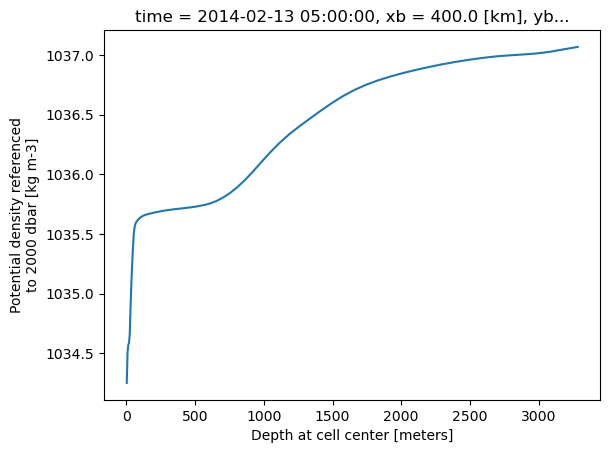

In [48]:
rho = xr.open_dataset("/g/data/nm03/ab8992/outputs/full-20/output100/rho/rho_y07.nc")
N = np.sqrt(
    ((9.8 / rho) * rho.differentiate("zl"))
    )
N.attrs = {"units":"s^-1"}

rho.isel(time = 100,yb = 0,xb = 100).rho.plot()

In [43]:
0.00232631 / 1e-4

23.263099999999998

In [42]:
(N.isel(time = 100,yb = 0,xb = 100).rho.fillna(0).integrate("zl") / 3000)

<xarray.DataArray 'rho' ()> Size: 8B
array(0.00232631)
Coordinates:
    time     object 8B 2014-02-13 05:00:00
    xb       float64 8B 400.0
    yb       float64 8B -32.0
    lon      float64 8B 151.2
    lat      float64 8B -44.23

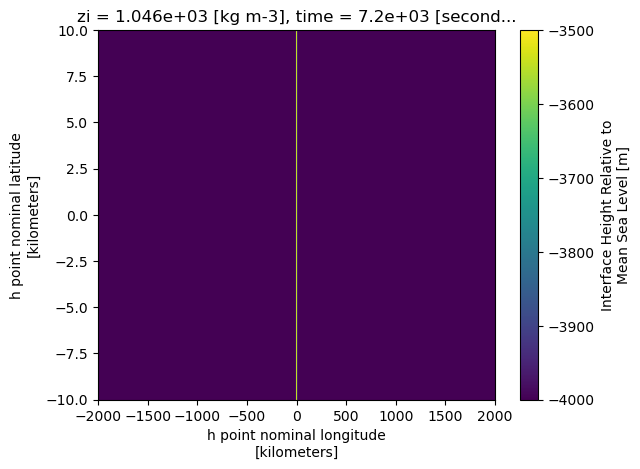

In [21]:
zonal.e.isel(zi = -1,time =5).plot()